# Dados Kaggle - Students Performance in Exams


*   **Autor:** Igor de Carvalho
*   **Data:** 03/11/2023
*   **Descrição:** Esse notebook apresenta uma análise do desempenho acadêmico de alunos, considerando uma base de dados ideal e já tratada.

---

**Etapas do processo de análise:**


1.   Importação das bibliotecas necessárias.
2.   Leitura da base de dados.
3.   Análise preliminar.
4.   Aplicação do algoritmo K-Means, utilizando o "método do cotovelo".
5.   Análise do K-Means.
6.   Aplicação do algoritmo de Regressão Linear.
7.   Análise da Árvore de Decisão.
8.   Conclusões.

## 1 - Importanção das bibliotecas necessárias

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## 2 - Leitura da base de dados

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Simos-Sigurd/TCC/main/Base%20de%20dados%20ideal%20(StudentsPerformance%20-%20Kaggle).csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Renomeando algumas colunas para deixar a leitura mais simples.

In [ ]:
df.rename(columns = {"gender":"Gênero","race/ethnicity":"Etnia","parental level of education":"Educacao_Pais",
                    "lunch":"Lanche","math score":"Matematica","reading score":"Leitura","writing score":"Escrita",
                    "test preparation course":"Pre_Teste"}, inplace = True)
df.head()

,Gênero,Etnia,Educacao_Pais,Lanche,Pre_Teste,Matematica,Leitura,Escrita
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 3 - Análise preliminar

Vamos checar a performance de cada campo entre homens e mulheres:

<ipython-input-4-bbd8a3683ed0>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3, idx+1)


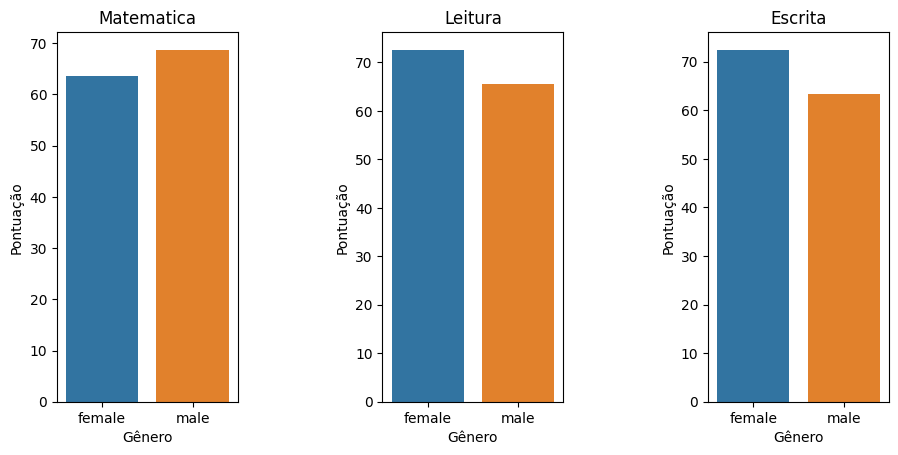

In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust(hspace=0.8, wspace=0.8, left = 0.2, right = 1.5)

for idx in range(3):
    plt.subplot(1,3, idx+1)
    gender_df = df.groupby("Gênero")[list(df.columns[-3:])[idx]].describe()
    sns.barplot(x = gender_df.index, y = gender_df.loc[:,"mean"].values)
    plt.ylabel("Pontuação")
    plt.title(list(df.columns[-3:])[idx])

plt.show()

Nós podemos ver que os homens tiveram uma performance melhor em Matemática, mas foram piores em Leitura e Escrita. Agora vamos ver a perfomance por Etnia:

<ipython-input-5-54ae1fd32069>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3, idx+1)


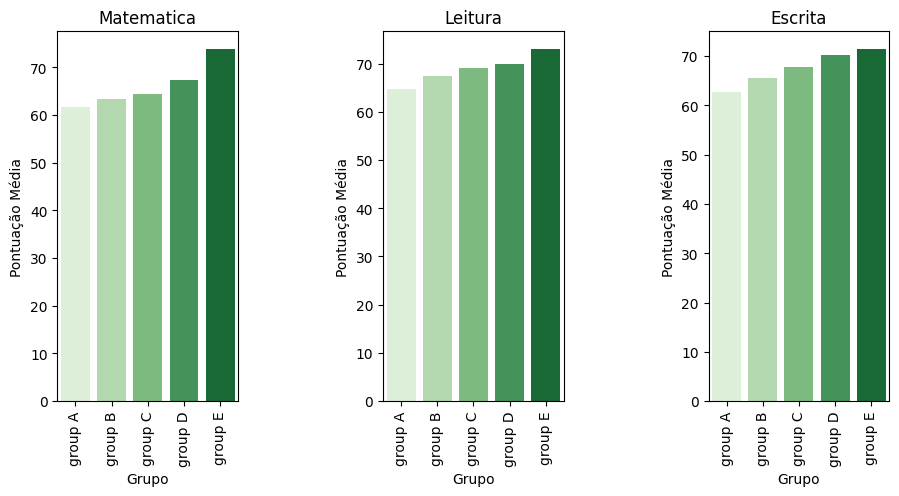

In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust(hspace=0.8, wspace=0.8, left = 0.2, right = 1.5)

for idx in range(3):
    plt.subplot(1,3, idx+1)
    ethn_df = df.groupby("Etnia")[list(df.columns[-3:])[idx]].mean()
    sns.barplot(x=ethn_df.index, y = ethn_df.values, palette = "Greens")
    plt.xlabel("Grupo")
    plt.ylabel("Pontuação Média")
    plt.xticks(rotation=90)
    plt.title(list(df.columns[-3:])[idx])

plt.show()

Fica claro que o Grupo E possui a melhor performance em todos os campos e o Grupo A possui a pior performance.

Vamos ver os resultados do teste de preparação:

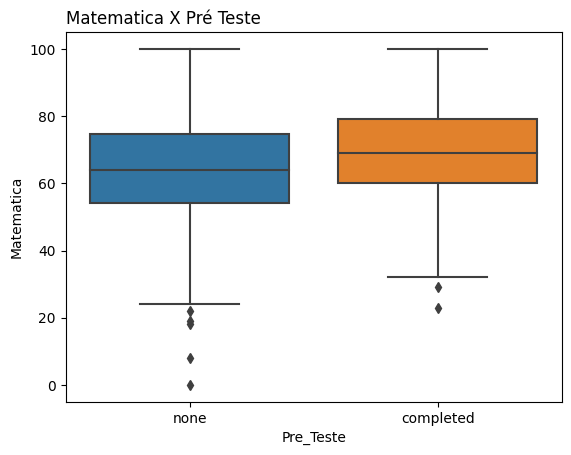

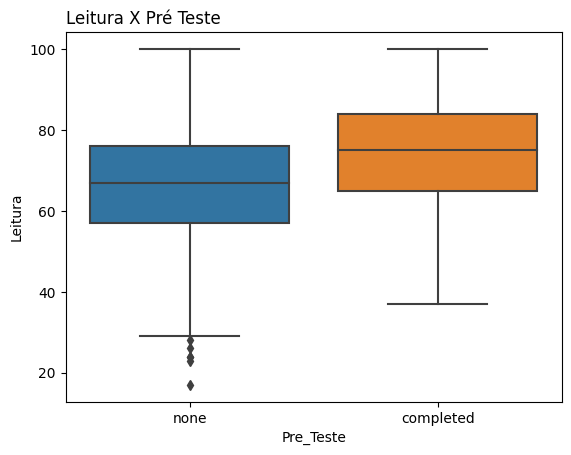

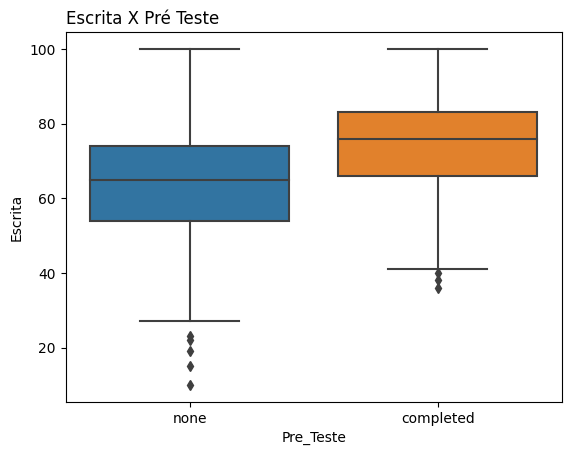

In [ ]:
for item in df.columns[-3:]:
  sns.boxplot(x = df["Pre_Teste"], y = df[item])
  plt.title(item + " X Pré Teste", loc = "left")
  plt.show()

A distribuição das notas fica mais próxima se os alunos completam o teste de prepação antes da prova. Também podemos perceber que a média de notas é melhor.

Vamos fazer o mesmo comparativo com a variável "Lanche":

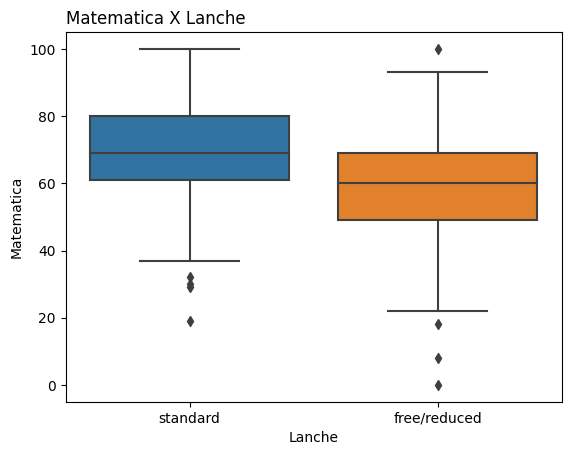

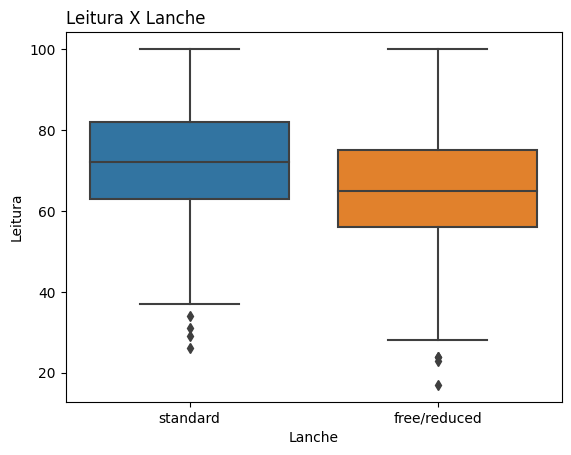

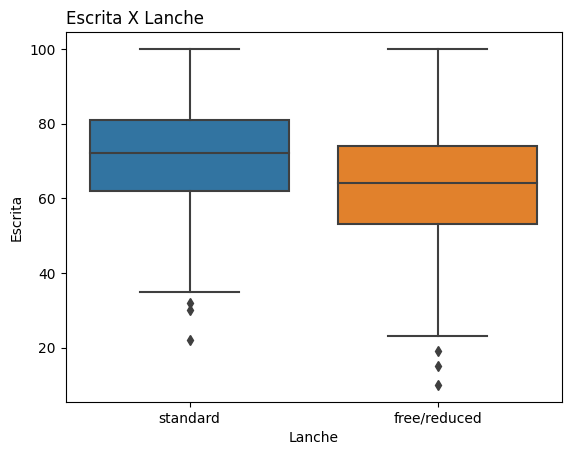

In [ ]:
for item in df.columns[-3:]:
  sns.boxplot(x = df["Lanche"], y = df[item])
  plt.title(item + " X Lanche", loc = "left")
  plt.show()

Faz sentido, os estudantes tendem a obter melhores resultados quando tem lanches regulares.

## 4 - Aplicação do K-Means

Vamos verificar os tipos de dados nas variáveis:

In [ ]:
df.dtypes

Gênero           object
Etnia            object
Educacao_Pais    object
Lanche           object
Pre_Teste        object
Matematica        int64
Leitura           int64
Escrita           int64
dtype: object

Vamos transformar algumas variáveis com o Label Encoder:

In [ ]:
labelencoder = LabelEncoder()

train_df = df.copy()
train_df["Educacao_Pais"] = labelencoder.fit_transform(train_df["Educacao_Pais"])
train_df["Pre_Teste"] = labelencoder.fit_transform(train_df["Pre_Teste"])
train_df["Lanche"] = labelencoder.fit_transform(train_df["Lanche"])

train_df.head()

,Gênero,Etnia,Educacao_Pais,Lanche,Pre_Teste,Matematica,Leitura,Escrita
0,female,group B,1,1,1,72,72,74
1,female,group C,4,1,0,69,90,88
2,female,group B,3,1,1,90,95,93
3,male,group A,0,0,1,47,57,44
4,male,group C,4,1,1,76,78,75


Agora que as variáveis "Educacao_Pais", "Lanche" e "Pre_Teste" estão classificadas por números, podemos usar o algoritmo KMeans para classificar o dataset. Para isso utilizaremos "Método do Cotovelo", que é um processo que busca encontrar o número ideal de clusters.

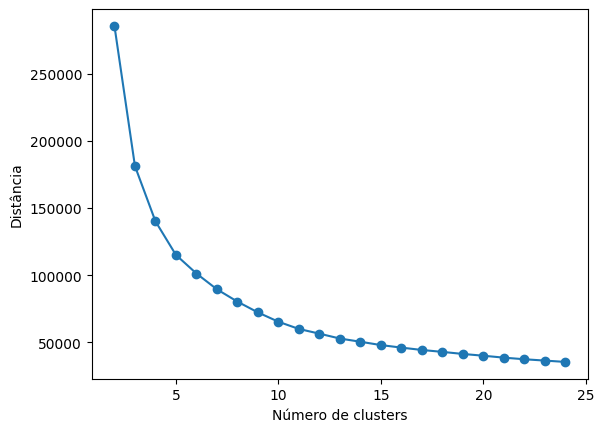

In [ ]:
kmeans_dis = list()

for idx in range(2, 25):
  kmeans = KMeans(init = "k-means++", n_clusters = idx, n_init = 20)
  kmeans.fit_transform(train_df.iloc[:, 2:])
  kmeans_dis.append(kmeans.inertia_)

plt.plot(list(range(2, 25)), kmeans_dis, marker = 'o')
plt.xlabel("Número de clusters")
plt.ylabel("Distância")
plt.show()

O gráfico acima demonstra a curva gerada pelo processo e a idéia é encotrarmos o "cotovelo" ou o ponto onde o aumento do número de clusters deixa de demonstrar uma discrepância significativa na distância. Vamos escolher 8 como o cotovelo (quantidade de clusters), depois classificamos todos os dados.

In [ ]:
kmeans = KMeans(init = "k-means++", n_clusters = 8)
kmeans.fit_transform(train_df.iloc[:, 2:])
kmeans_label = kmeans.labels_
df["Classificacao"] = kmeans_label
df.head(10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Gênero,Etnia,Educacao_Pais,Lanche,Pre_Teste,Matematica,Leitura,Escrita,Classificacao
0,female,group B,bachelor's degree,standard,none,72,72,74,3
1,female,group C,some college,standard,completed,69,90,88,2
2,female,group B,master's degree,standard,none,90,95,93,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,7
4,male,group C,some college,standard,none,76,78,75,3
5,female,group B,associate's degree,standard,none,71,83,78,3
6,female,group B,some college,standard,completed,88,95,92,1
7,male,group B,some college,free/reduced,none,40,43,39,4
8,male,group D,high school,free/reduced,completed,64,64,67,5
9,female,group B,high school,free/reduced,none,38,60,50,7


Agora vamos ver a performance de cada cluster:

In [ ]:
class_df = df.groupby(["Classificacao"])[df.columns[-4:-1]].mean()
class_df

,Matematica,Leitura,Escrita
Classificacao,,,
0,61.912000,58.040000,56.096000
1,88.967391,93.076087,92.836957
2,81.690323,82.109677,80.954839
3,67.505952,77.333333,76.928571
4,32.135135,35.972973,33.594595
5,56.722973,66.472973,66.675676
6,73.338346,68.789474,67.120301
7,48.056338,51.507042,49.232394


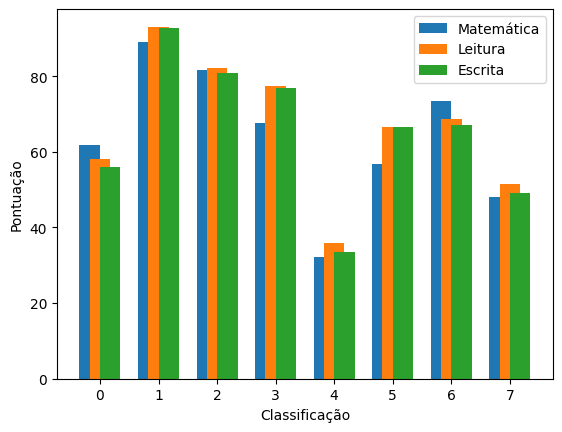

In [ ]:
ind = np.arange(8)
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, class_df.Matematica, width, label="Matemática")
rects2 = ax.bar(ind, class_df.Leitura, width, label="Leitura")
rects3 = ax.bar(ind + width/2, class_df.Escrita, width, label="Escrita")

ax.set_xlabel("Classificação")
ax.set_ylabel("Pontuação")
ax.set_xticks(ind)
ax.legend()
plt.show()

Até o momento, está claro que todo o conteúdo do cluster tem a mesma tendência, então vamos escolher a média de todo o conteúdo para realizar o ranking dos clusters:

In [ ]:
class_df["Media_Total_Pontos"] = (class_df.Matematica + class_df.Leitura + class_df.Escrita) / 3
rank = class_df["Media_Total_Pontos"].sort_values(ascending = False)
rank.index

Int64Index([1, 2, 3, 6, 5, 0, 7, 4], dtype='int64', name='Classificacao')

In [ ]:
rank

Classificacao
1    91.626812
2    81.584946
3    73.922619
6    69.749373
5    63.290541
0    58.682667
7    49.598592
4    33.900901
Name: Media_Total_Pontos, dtype: float64

## 5 - Análise do K-Means

A partir de agora, podemos achar a correlação entre a performance dos alunos. Vamos exibir em gráficos de pizza para ver se o nível de educação dos pais pode afetar a performance ou não.

<ipython-input-16-eadbab6d70e2>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, idx+1)


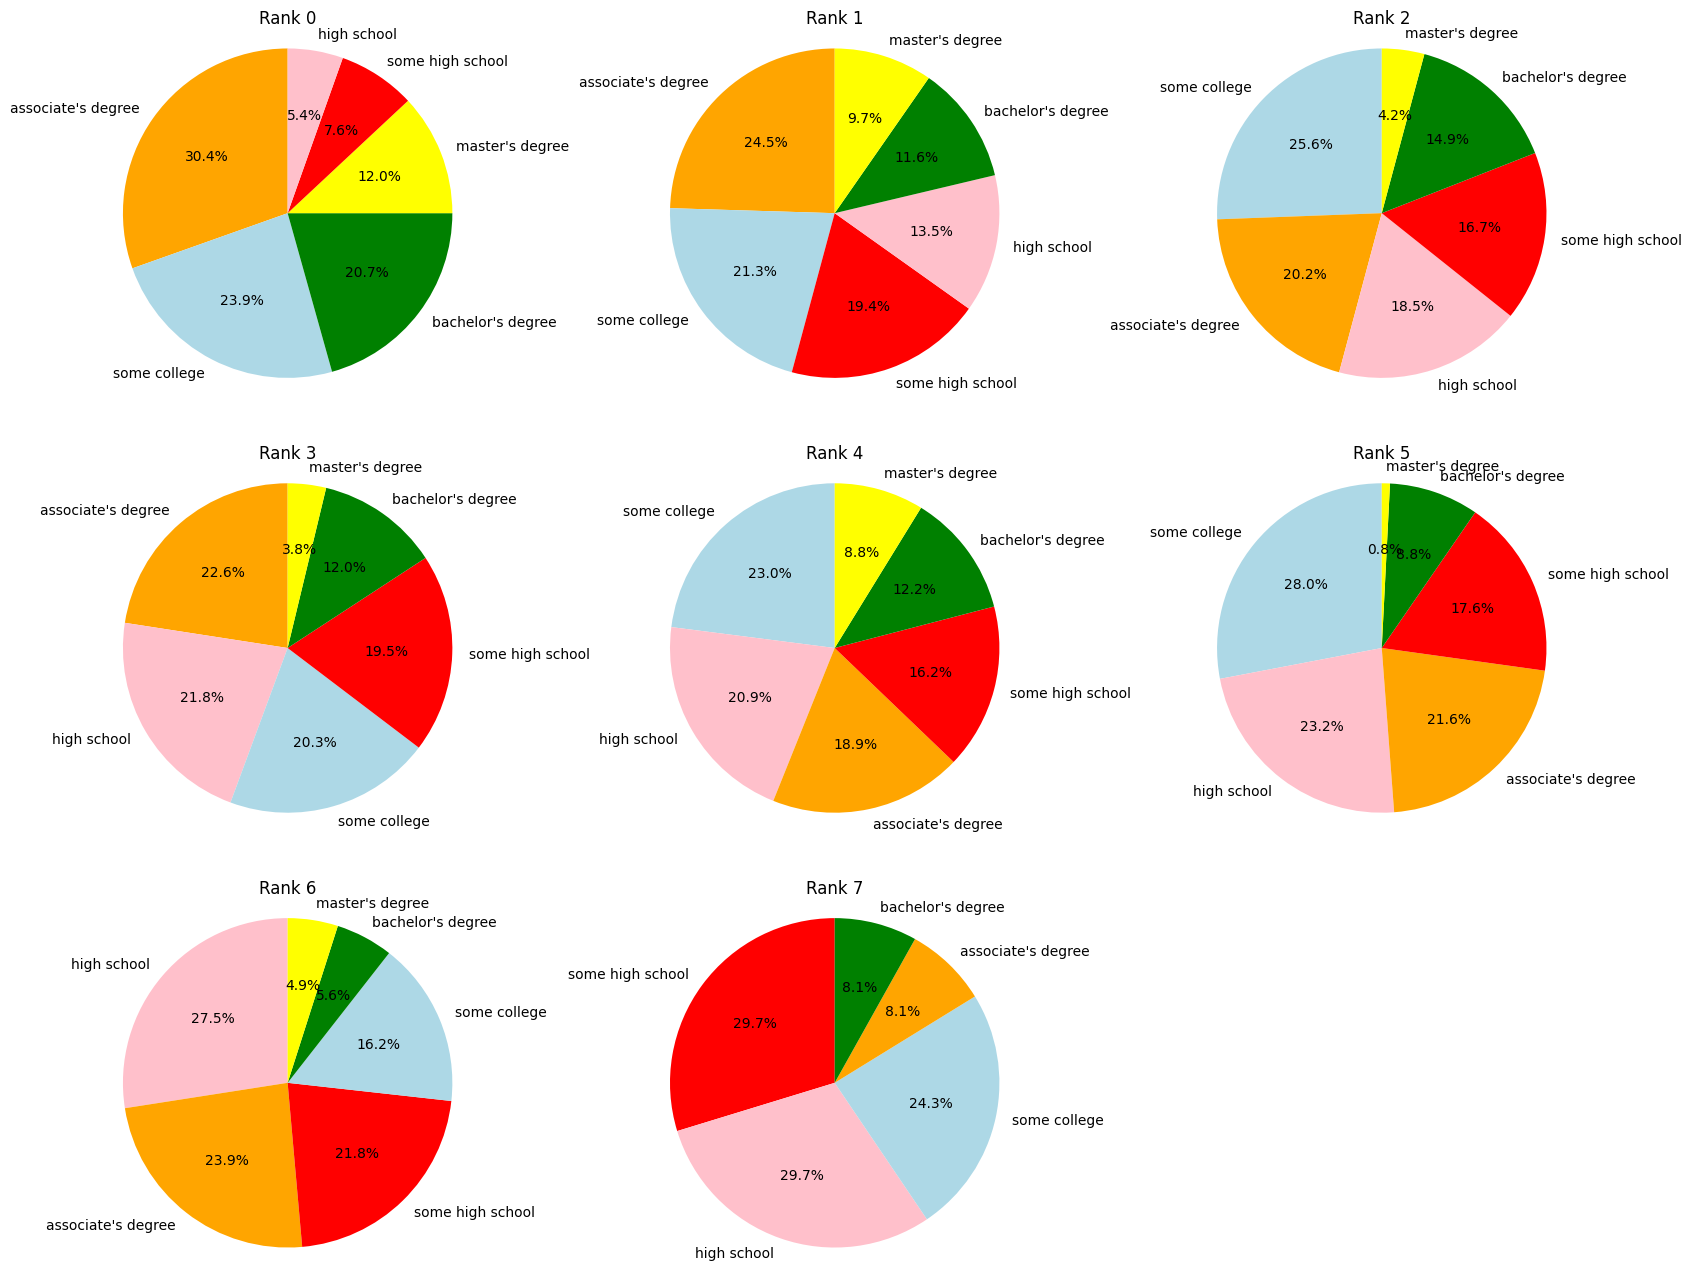

In [ ]:
def plot_pie_chart(column):
    fig, ax = plt.subplots(figsize=(20,16))
    custom_colors = {
        "high school":"pink",
        "some high school":"red",
        "master's degree":"yellow",
        "bachelor's degree":"green",
        "some college":"lightblue",
        "associate's degree":"orange"
    }
    for idx in range(8):
        plt.subplot(3, 3, idx+1)
        num = "class" + str(idx)
        num = df[df["Classificacao"]==rank.index[idx]]
        percentage_of_parent_edu = num[column].value_counts()
        percentage_of_parent_edu.sort_index()
        label = percentage_of_parent_edu.index
        value = percentage_of_parent_edu.values
        colors = [custom_colors.get(var, 'blue') for var in label]
        plt.pie(value, labels = label, autopct = "%1.1f%%",
                startangle=90, radius = 4, colors = colors[:len(label)])
        plt.axis("equal")
        plt.title("Rank " + str(idx))
    plt.show()
plot_pie_chart("Educacao_Pais")

Vamos definir como alto nível de educação pais que possuam Bacharel (bachelor's degree) ou Mestrado (master's degree), então vamos focar nesses dois termos.

Como mostrado nos gráficos acima, podemos ver facilmente a proporção de alto nível de educação. Para o Rank 0, seu índice gira em torno de 32%. Além disso, não há diferenças entre os Ranks 1 e 4, e a proporção é de aproximadamente 21%. Por final, a proporção é de apenas 8% no Rank 7.

Nós calculamos a média de pontuação de cada Rank anteriormente, então podemos dizer que o nível de educação dos pais causa uma influência no resultado dos alunos, mas não de maneira significativa pois ainda temos cerca de 70% ~ 80% dos pais sem um alto nível de educação.

E quanto ao Teste de Preparação? Vamos verificar:

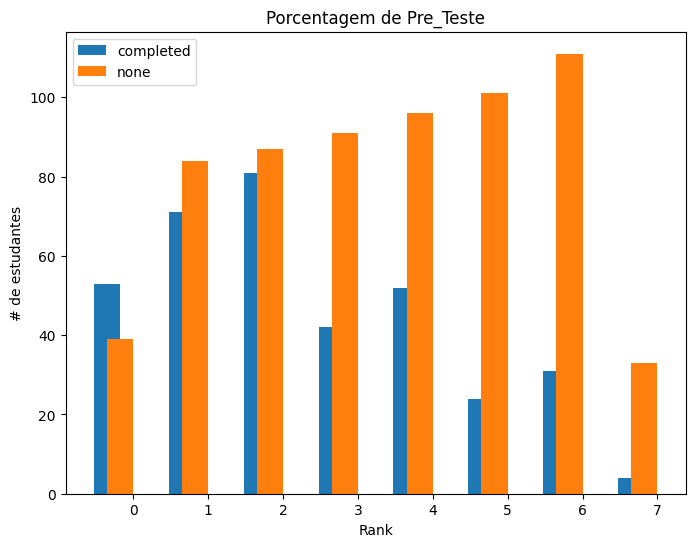

In [ ]:
def plot_bar_chart(column):
    fig, ax = plt.subplots(figsize=(8,6))
    index_dict = dict()
    width = 0.35
    ind = np.arange(8)
    for idx in range(8):
        num = "class" + str(idx)
        num = df[df["Classificacao"] == rank.index[idx]]
        porcent_da_coluna = num[column].value_counts()
        porcent_da_coluna = porcent_da_coluna.sort_index()
        for key in porcent_da_coluna.index:
          if key not in index_dict.keys():
            index_dict[key] = []
            index_dict[key].append(porcent_da_coluna[key])
          else:
            index_dict[key].append(porcent_da_coluna[key])
    porcent_da_coluna = df[df["Classificacao"] == rank.index[4]][column].value_counts().sort_index()
    for i in range(len(porcent_da_coluna.index)):
      rects = ax.bar(ind - width / (i + 1), index_dict[porcent_da_coluna.index[i]], width, label = porcent_da_coluna.index[i])

    ax.set_xlabel("Rank")
    ax.set_ylabel("# de estudantes")
    ax.set_title("Porcentagem de " + column)
    ax.set_xticks(ind)
    ax.legend()
    plt.show()

plot_bar_chart("Pre_Teste")

Mais de 50% dos estudantes no Rank 0 completaram o teste de preparação e tem aproximadamente 70% ~ 80% de estudantes no Rank 7 que não finalizaram. É dito que o teste de preparação pode ajudar os estudantes a conseguir melhores notas.

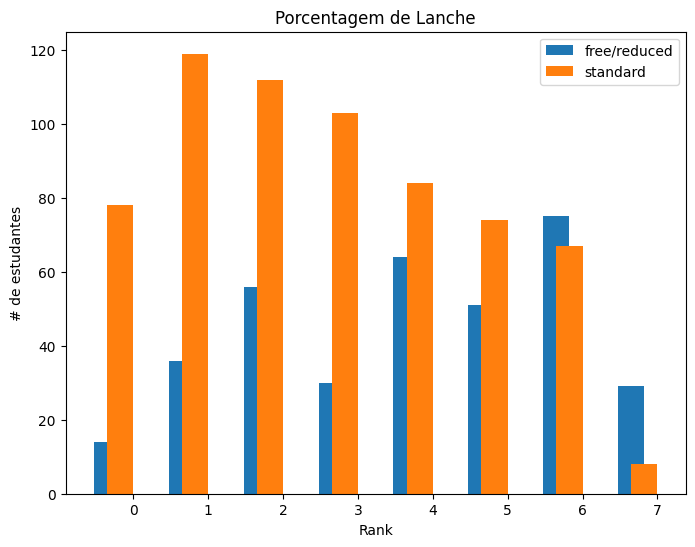

In [ ]:
plot_bar_chart("Lanche")

Verificando a variável "Lanche", percebemos a mesma tendência do "Pre_Teste". Alunos que lancham regularmente antes do teste conseguem resultados melhores, ou seja, é difícil conseguir uma boa performance sem se alimentar.

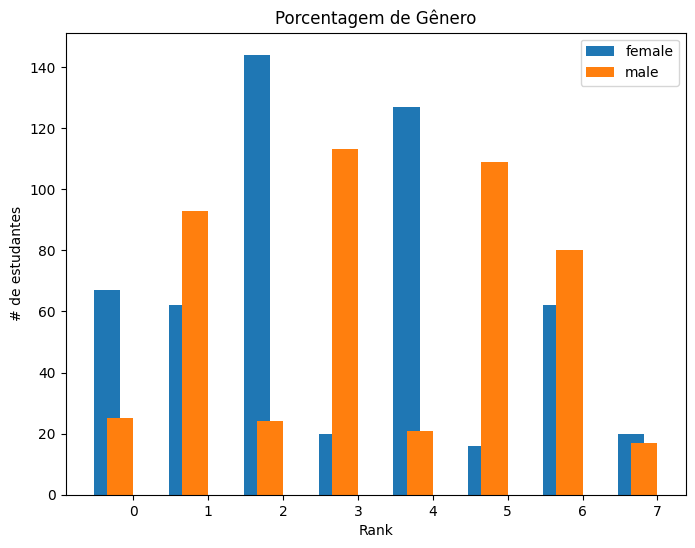

In [ ]:
plot_bar_chart("Gênero")

É difícil dizer que os homens tiveram um desempenho melhor que o das mulheres.

In [ ]:
labelencoder = LabelEncoder()

tree_df = df.copy()
tree_df["Educacao_Pais"] = labelencoder.fit_transform(tree_df["Educacao_Pais"])
tree_df["Pre_Teste"] = labelencoder.fit_transform(tree_df["Pre_Teste"])
tree_df["Lanche"] = labelencoder.fit_transform(tree_df["Lanche"])
tree_df.drop("Etnia", axis = 1, inplace = True)
tree_df.drop("Gênero", axis = 1, inplace = True)
tree_df.drop("Classificacao", axis = 1, inplace = True)

tree_df.head()

,Educacao_Pais,Lanche,Pre_Teste,Matematica,Leitura,Escrita
0,1,1,1,72,72,74
1,4,1,0,69,90,88
2,3,1,1,90,95,93
3,0,0,1,47,57,44
4,4,1,1,76,78,75


In [ ]:
tree_df["Media"] = tree_df[["Matematica", "Leitura", "Escrita"]].mean(axis = 1).round(0)

tree_df.head()

,Educacao_Pais,Lanche,Pre_Teste,Matematica,Leitura,Escrita,Media
0,1,1,1,72,72,74,73.0
1,4,1,0,69,90,88,82.0
2,3,1,1,90,95,93,93.0
3,0,0,1,47,57,44,49.0
4,4,1,1,76,78,75,76.0


In [ ]:
tree_df.dtypes

Educacao_Pais    int64
Lanche           int64
Pre_Teste        int64
Matematica       int64
Leitura          int64
Escrita          int64
dtype: object

In [ ]:
X = tree_df.drop("Matematica", axis = 1)
y = tree_df["Matematica"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE (Erro Quadrático Médio):", mse)
print("R^2 (Coeficiente de Determinação):", r2)

MSE (Erro Quadrático Médio): 151.8525
R^2 (Coeficiente de Determinação): 0.37596162381276443


## 6 - Aplicação da Regressão Linear

Vamos nos certificar que todas as variáveis do dataset contém dados numéricos

In [ ]:
labelencoder = LabelEncoder()

rl_df = train_df.copy()
rl_df["Gênero"] = labelencoder.fit_transform(rl_df["Gênero"])
rl_df["Etnia"] = labelencoder.fit_transform(rl_df["Etnia"])

rl_df.head()

,Gênero,Etnia,Educacao_Pais,Lanche,Pre_Teste,Matematica,Leitura,Escrita
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75


Agora vamos aplicar o modelo de Regressão Linear, com a divisão de 20% dos dados para teste e 80% para predição.

Vamos verificar o desempenho individualmente de cada competência, começando por Matemática

In [ ]:
prova_alvo = 'Matematica'

X = rl_df.drop(prova_alvo, axis=1)
y = rl_df[prova_alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE (Erro Quadrático Médio):", mse)
print("R^2 (Coeficiente de Determinação):", r2)

MSE (Erro Quadrático Médio): 28.275284506327335
R^2 (Coeficiente de Determinação): 0.8838026201112223


O modelo apresenta um bom desempenho

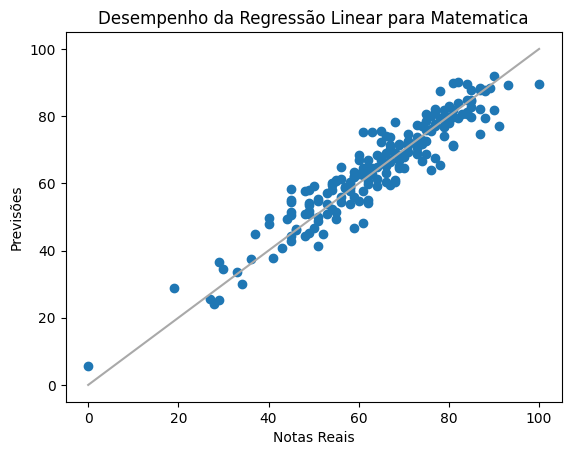

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Notas Reais")
plt.ylabel("Previsões")
plt.title("Desempenho da Regressão Linear para " + prova_alvo)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='darkgrey', linestyle='-')
plt.show()

Vejamos o desempenho com a prova de Leitura agora:

In [ ]:
prova_alvo = 'Leitura'

X = rl_df.drop(prova_alvo, axis=1)
y = rl_df[prova_alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE (Erro Quadrático Médio):", mse)
print("R^2 (Coeficiente de Determinação):", r2)

MSE (Erro Quadrático Médio): 19.17721487903718
R^2 (Coeficiente de Determinação): 0.915251705386034


O modelo segue mantendo um bom desempenho

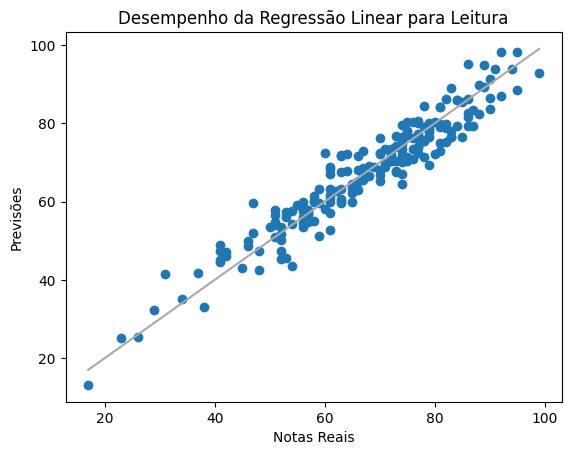

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Notas Reais")
plt.ylabel("Previsões")
plt.title("Desempenho da Regressão Linear para " + prova_alvo)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='darkgrey', linestyle='-')
plt.show()

Por último, a competência de Escrita:

In [ ]:
prova_alvo = 'Escrita'

X = rl_df.drop(prova_alvo, axis=1)
y = rl_df[prova_alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE (Erro Quadrático Médio):", mse)
print("R^2 (Coeficiente de Determinação):", r2)

MSE (Erro Quadrático Médio): 16.587981140277076
R^2 (Coeficiente de Determinação): 0.9311750504698805


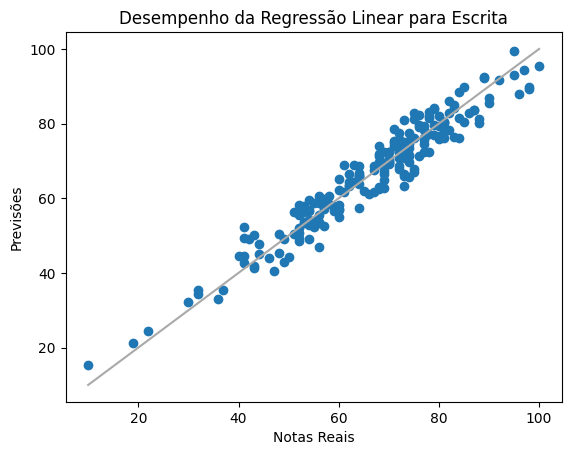

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Notas Reais")
plt.ylabel("Previsões")
plt.title("Desempenho da Regressão Linear para " + prova_alvo)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='darkgrey', linestyle='-')
plt.show()

## 7 - Análise da Regressão Linear

Apesar do modelo de Regressão Linear ter se portado bem, já vimos que as variáveis Gênero e Etnia não parecem ser determinantes para o desempenho dos alunos, portanto vamos fazer alguns comparativos com as outras variáveis.

Para facilitar, vamos trazer novamente a variável que contém a Média Total de Pontos:

In [ ]:
rl_df["Media_Total_Pontos"] = ((rl_df.Matematica + rl_df.Leitura + rl_df.Escrita) / 3).round(2)

rl_df.head()

,Gênero,Etnia,Educacao_Pais,Lanche,Pre_Teste,Matematica,Leitura,Escrita,Media_Total_Pontos
0,0,1,1,1,1,72,72,74,72.67
1,0,2,4,1,0,69,90,88,82.33
2,0,1,3,1,1,90,95,93,92.67
3,1,0,0,0,1,47,57,44,49.33
4,1,2,4,1,1,76,78,75,76.33


Já estabelecemos previamente que para o nível de educação dos pais, um alto nível seria considarado para aqueles que possuem Bacharel ou Mestrado. Vamos então separar dois subconjuntos, um com os pais que possuem alto nível de educação e os que não poussuem. Em seguida aplicaremos o modelo de Regressão Linear na Média Total de Pontos

In [ ]:
# Subconjunto com alto nível de educação
alta_educacao = rl_df[rl_df['Educacao_Pais'].isin([1, 3])]
X_alta = alta_educacao[['Pre_Teste', 'Lanche', 'Leitura', 'Escrita', 'Matematica']]
y_alta = alta_educacao['Media_Total_Pontos']

# Subconjunto com baixo nível de educação
baixa_educacao = rl_df[~rl_df['Educacao_Pais'].isin([1, 3])]
X_baixa = baixa_educacao[['Pre_Teste', 'Lanche', 'Leitura', 'Escrita', 'Matematica']]
y_baixa = baixa_educacao['Media_Total_Pontos']

model_alta = LinearRegression()
model_baixa = LinearRegression()

model_alta.fit(X_alta, y_alta)
model_baixa.fit(X_baixa, y_baixa)

mse_alta = ((model_alta.predict(X_alta) - y_alta) ** 2).mean()
mse_baixa = ((model_baixa.predict(X_baixa) - y_baixa) ** 2).mean()

r2_alta = model_alta.score(X_alta, y_alta)
r2_baixa = model_baixa.score(X_baixa, y_baixa)

print(f'MSE (Alto nível de educação): {mse_alta}')
print(f'MSE (Baixo nível de educação): {mse_baixa}')

print(f'R^2 (Alto nível de educação): {r2_alta}')
print(f'R^2 (Baixo nível de educação): {r2_baixa}')

MSE (Alto nível de educação): 6.782382868713716e-06
MSE (Baixo nível de educação): 7.34011672999754e-06
R^2 (Alto nível de educação): 0.999999964269621
R^2 (Baixo nível de educação): 0.9999999633205722


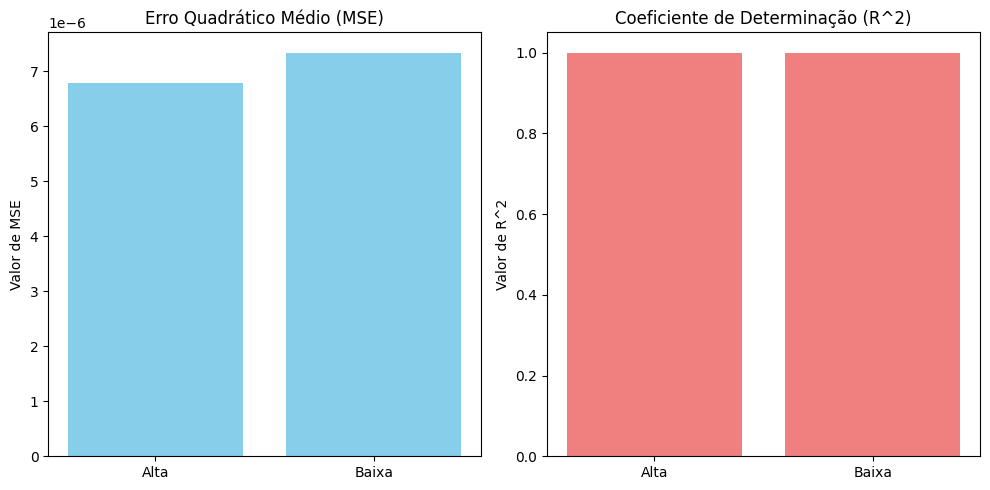

In [ ]:
valores_mse = [mse_alta, mse_baixa]
valores_r2 = [r2_alta, r2_baixa]
educacao = ['Alta', 'Baixa']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(educacao, valores_mse, color='skyblue')
plt.title('Erro Quadrático Médio (MSE)')
plt.ylabel('Valor de MSE')

plt.subplot(1, 2, 2)
plt.bar(educacao, valores_r2, color='lightcoral')
plt.title('Coeficiente de Determinação (R^2)')
plt.ylabel('Valor de R^2')

plt.tight_layout()

plt.show()

Façamos agora o mesmo para a variável do teste preparatório:

In [ ]:
# Subconjunto de quem fez o teste preparatório
com_teste = rl_df[rl_df['Pre_Teste'] == 0]
X_com = com_teste[['Educacao_Pais', 'Lanche', 'Leitura', 'Escrita', 'Matematica']]
y_com = com_teste['Media_Total_Pontos']

# Subconjunto de quem não fez o teste preparatório
sem_teste = rl_df[rl_df['Educacao_Pais'] == 1]
X_sem = sem_teste[['Educacao_Pais', 'Lanche', 'Leitura', 'Escrita', 'Matematica']]
y_sem = sem_teste['Media_Total_Pontos']

model_com = LinearRegression()
model_sem = LinearRegression()

model_com.fit(X_com, y_com)
model_sem.fit(X_sem, y_sem)

mse_com = ((model_com.predict(X_com) - y_com) ** 2).mean()
mse_sem = ((model_sem.predict(X_sem) - y_sem) ** 2).mean()

r2_com = model_com.score(X_com, y_com)
r2_sem = model_sem.score(X_sem, y_sem)

print(f'MSE (Fez teste preparatório): {mse_com}')
print(f'MSE (Não fez teste preparatório): {mse_sem}')

print(f'R^2 (Fez teste preparatório): {r2_com}')
print(f'R^2 (Não fez teste preparatórioo): {r2_sem}')

MSE (Fez teste preparatório): 7.08677893005147e-06
MSE (Não fez teste preparatório): 6.260393256075972e-06
R^2 (Fez teste preparatório): 0.9999999581881133
R^2 (Não fez teste preparatórioo): 0.999999967541219


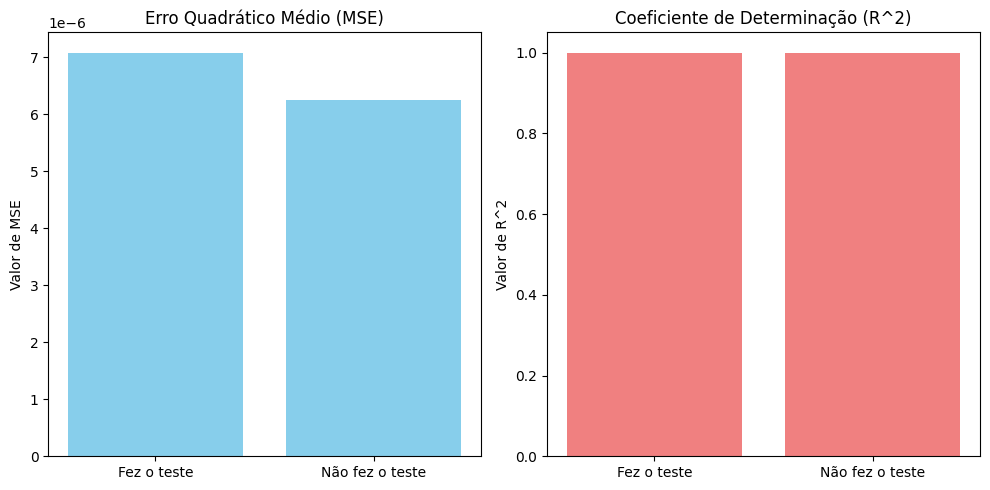

In [ ]:
valores_mse = [mse_com, mse_sem]
valores_r2 = [r2_com, r2_sem]
pre_teste = ['Fez o teste', 'Não fez o teste']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(pre_teste, valores_mse, color='skyblue')
plt.title('Erro Quadrático Médio (MSE)')
plt.ylabel('Valor de MSE')

plt.subplot(1, 2, 2)
plt.bar(pre_teste, valores_r2, color='lightcoral')
plt.title('Coeficiente de Determinação (R^2)')
plt.ylabel('Valor de R^2')

plt.tight_layout()

plt.show()

## 8 - Conclusões

Podemos tirar algumas conclusões:

1.   O nível de educação dos pais pode afetar a performance dos estudantes, mas não é o fator mais importante.
2.   Terminar o teste de preparação é muito beneficial.
3.   Se alimentar é importante para os estudantes, e aparenta ser um fator importante.
4.   O gênero não aparenta ter uma relação com a pontuação.